### Problem Set 6: Introduction to PyTorch

**Release Date:** 19 March 2024

**Due Date:** 23:59, 06 April 2024

In the real world, while fundamentals are welcomed and appreciated, implementing algorithms from scratch is time consuming, especially when it comes to Deep Learning (DL) models like neural networks with many layers. Backpropagating manually or by hand is often tedious and erroneous. Which is why, it is absolutely critical to learn **at least one** Machine Learning library, either to get jobs or build projects in this field. As such, in *Problem Set 6*, we will introduce you to **PyTorch**.

<img src="imgs/img_logo.png" width="600">

`PyTorch` is one of the largest DL libaries widely used around the globe. It offers a very Pythonic API to build layers and compose them together. In fact, data processing is also made easy using the multitude of tools and wrappers that are at your disposal – it is the complete workbench. Of course, there are other popular libraries such as `TensorFlow`, but they require you to understand how to understand "computation graphs," and thus we feel are less accessible for beginners. Hence, we decided to use PyTorch for CS2109S. 

In *Problem Set 6*, we will attempt to help you learn the `PyTorch` API by having you build a simple deep neural network and training it locally on your system via backpropagation and stochastic gradient descent. Subsequently, you will also learn how to build data processing pipelines to prepare your data before ingestion into your model(s).

In [1]:
# RUN THIS CELL FIRST
import math
from collections import OrderedDict

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from numpy import allclose, isclose

# 1 Tensors in PyTorch

### 1.1 Concept - What are Tensors?

In Linear Algebra, you've learned about vectors – they are 1-dimensional (1D) serial arrays (like `[1, 2, 3, 4, 23, 18]`) containing a column (or row) of information. You've also learned about matrices – they are "rectangles" (i.e., 2D) that also capture elements.

**Tensors** generalise the concept of matrices: they are $n$-dimensional arrays that contain or represent information. In *PyTorch*, everything is defined as a `tensor`. It's analogous to `np.array(...)` from *NumPy*. A `tensor` object in *PyTorch* looks like this:

<img src="imgs/img_tensors.png" width="600">


---
The following are some mappings of useful functions between Numpy and Pytorch, in fact, they are so similar that there is a function `torch.from_numpy(ndarray)` which transforms a numpy array into a pytorch tensor! The main difference in the functions in the table below is that Numpy and Pytorch functions takes as input and gives as output numpy array or torch tensors respectively. PyTorch tensors also have additional functionality for GPU acceleration. Refer to this [website](https://pytorch-for-numpy-users.wkentaro.com/) for more information.

<img src="imgs/img_numpy_pytorch.png" width="600">

### 1.1.1 Demo - Tensor functions

Notice that tensors have a `.grad` attribute. This is used for automatic gradient computation.  
To create tensors, you can use the `torch.tensor(...)` constructor:  

A 0-dimensional tensor: `torch.tensor(5.0)`  
A 1-dimensional tensor: `torch.tensor([1.0, 2.0, 3.0])`  
A 2-dimensional tensor: `torch.tensor([[.4, .3], [.1, .2]])`  

If automatic gradient computation is required, then the equivalent constructors will be:  
`torch.tensor(5.0, requires_grad=True)`  
`torch.tensor([1.0, 2.0, 3.0], requires_grad=True)`  
`torch.tensor([[.4, .3], [.1, .2]], requires_grad=True)`  

We can call detach() on these tensors to stop them from being traced for gradient computation, returning us the tensors without requires_grad=True.

We can call item() on our tensors to return the value of our tensor as a standard python number:

`>>> torch.tensor([1.0]).item()
1.0`

The following code block shows how we can make use of all these functions introduced.

In [2]:
# Create a tensor with requires_grad set to True
x = torch.tensor([2.0], requires_grad=True)

# Compute the gradient of a simple expression using backward
y = x**2 + 2 * x
y.backward()

# Print the derivative value of y i.e dy/dx = 2x + 2 = 6.0.
print("Gradient of y with respect to x:", x.grad)

# Detach the gradient of x
x = x.detach()

# Print the gradient of x after detachment
print("Gradient of x after detachment:", x.grad)

# Extract the scalar value of a tensor as a Python number
x_value = x.item()
print("Value of x as a Python number:", x_value)

Gradient of y with respect to x: tensor([6.])
Gradient of x after detachment: None
Value of x as a Python number: 2.0


### 1.1.2 Demo - Working with Tensors

Here, we use `torch.linspace` to create a `torch.tensor`. In PyTorch, and Machine Learning in general, tensors form the basis of all operations.

We then make use of the built-in *PyTorch* function `torch.sin` to create the corresponding y-values of a sine function, and plot the points using *Matplotlib*.

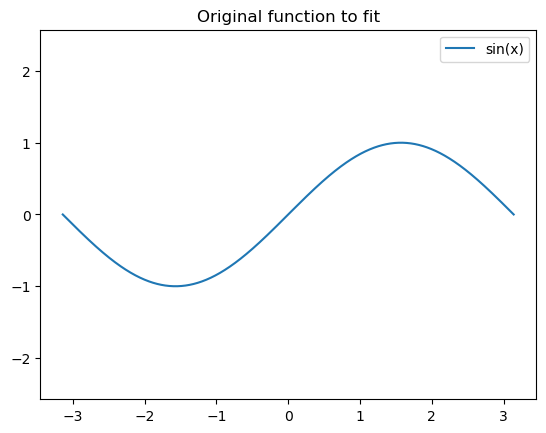

In [3]:
# This is a demonstration: You just need to run this cell without editing.

x = torch.linspace(-math.pi, math.pi, 1000) # Task 1.1: What is torch.linspace?
y_true = torch.sin(x)

plt.plot(x, y_true, linestyle='solid', label='sin(x)')
plt.axis('equal')
plt.title('Original function to fit')
plt.legend()
plt.show()

In [4]:
# Run this cell to explore what the FIRST 10 VALUES of x has been assigned to.
# By default, each cell will always print the output of the last expression in the cell
# You can explore what x is by modifying the expression e.g. x.max(), x.shape
x[:10]

tensor([-3.1416, -3.1353, -3.1290, -3.1227, -3.1164, -3.1101, -3.1039, -3.0976,
        -3.0913, -3.0850])

### Task 1.1 - What is `torch.linspace`?

From the example above, answer the following questions:

1. What does `x = torch.linspace(-math.pi, math.pi, 1000)` do?  
2. How many values are stored in `x`?  
3. What are the minimum and maximum values in `x`?  

### 1.2.1 Demo - Using Tensors for linear regression

For this example, we fit a **degree 3 polynomial** to the sine function, using a learning rate of 1e-6 and 5000 iterations.

iter	loss	
----	----
1000	0.4506033957004547
2000	0.4224050045013428
3000	0.40602096915245056
4000	0.396359920501709
5000	0.39052513241767883


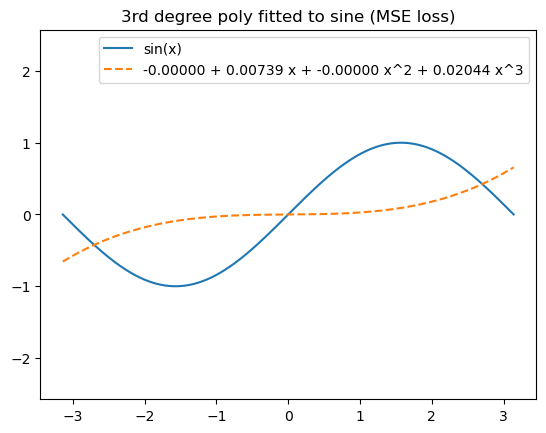

In [5]:
# This is a demonstration: You just need to run this cell without editing.

# Set learning rate
learning_rate = 1e-6

# Initialize weights to 0
a = torch.tensor(0.)
b = torch.tensor(0.)
c = torch.tensor(0.)
d = torch.tensor(0.)

print('iter', 'loss', '\n----', '----', sep='\t')
for t in range(1, 5001): # 5000 iterations
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x**2 + d * x**3

    # Compute MSE loss
    loss = torch.mean(torch.square(y_pred - y_true))
    if t % 1000 == 0:
        print(t, loss.item(), sep='\t')

    # Backpropagation
    grad_y_pred = 2.0 * (y_pred - y_true) / y_pred.shape[0]
    
    # Compute gradients of a, b, c, d with respect to loss
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Update weights using gradient descent
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

# print fitted polynomial
equation = f'{a:.5f} + {b:.5f} x + {c:.5f} x^2 + {d:.5f} x^3'

y_pred = a + b * x + c * x**2 + d * x**3
plt.plot(x, y_true, linestyle='solid', label='sin(x)')
plt.plot(x, y_pred, linestyle='dashed', label=f'{equation}')
plt.axis('equal')
plt.title('3rd degree poly fitted to sine (MSE loss)')
plt.legend()
plt.show()

### 1.2.2 Demo - Using autograd to automatically compute gradients

In the previous example, we explicitly computed the gradient for Mean Squared Error (MSE):  
`grad_y_pred = 2.0 * (y_pred - y_true) / y_pred.shape[0]`

In the next example, we will use PyTorch's autograd functionality to help us compute the gradient for **Mean Absolute Error (MAE)**.  
In order to compute the gradients, we will use the `.backward()` method of *PyTorch* tensors.

Once again, we fit a **degree 3 polynomial** to the sine function, using a learning rate of `1e-6` and `5000` iterations.  
This time, we will use MAE instead of MSE.

iter	loss	
----	----
1000	0.5974264740943909
2000	0.5801820755004883
3000	0.5707745552062988
4000	0.565079927444458
5000	0.5613779425621033


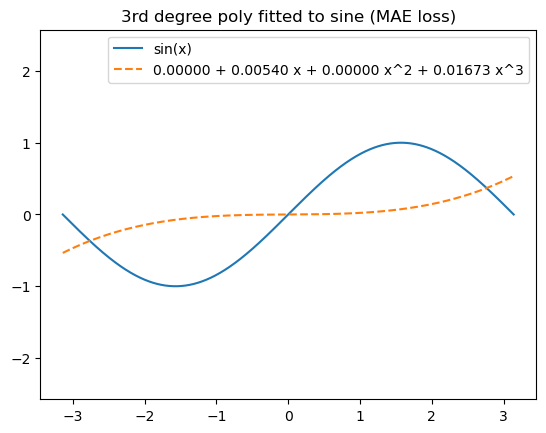

In [6]:
# This is a demonstration: You just need to run this cell without editing.

# Set learning rate
learning_rate = 1e-6

# Initialize weights to 0
a = torch.tensor(0., requires_grad=True)
b = torch.tensor(0., requires_grad=True)
c = torch.tensor(0., requires_grad=True)
d = torch.tensor(0., requires_grad=True)

print('iter', 'loss', '\n----', '----', sep='\t')
for t in range(1, 5001):
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute MAE loss
    loss = torch.mean(torch.abs(y_pred - y_true))
    if t % 1000 == 0:
        print(t, loss.item(), sep='\t')

    # Automatically compute gradients
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad
        a.grad.zero_() # reset gradients !important
        b.grad.zero_() # reset gradients !important
        c.grad.zero_() # reset gradients !important
        d.grad.zero_() # reset gradients !important
        # What happens if you don't reset the gradients?

# print fitted polynomial
equation = f'{a:.5f} + {b:.5f} x + {c:.5f} x^2 + {d:.5f} x^3'

y_pred = a + b * x + c * x ** 2 + d * x ** 3
plt.plot(x, y_true, linestyle='solid', label='sin(x)')
plt.plot(x, y_pred.detach().numpy(), linestyle='dashed', label=f'{equation}')
plt.axis('equal')
plt.title('3rd degree poly fitted to sine (MAE loss)')
plt.legend()
plt.show()

### Task 1.2 - Polyfit model

We have demonstrated how to fit a degree-3 polynomial to a set of `x` and `y` points (following the sine curve), using two different types of loss functions (MSE and MAE).  

Now, your task is to write a function `polyfit` that takes in some arbitrary set of points. You are only allowed to use **ONE** loop for the backpropagation and weights update. You are **NOT** allowed to use a loop to raise the features to their respective powers.
1. `x`, corresponding x-values,  
2. `y`, corresponding true y-values,  
3. `loss_fn` to compute the loss, given the true `y` and predicted `y`,  
4. `n` representing the $n$-degree polynomial, and 
5. `lr` learning rate, and  
6. `n_iter` for the number of times to iterate.  

Return the 1D tensor containing the coefficients of the $n$-degree polynomial , after fitting the model.  
The coefficients should be arranged in ascending powers of $x$.

For example,
```
>>> y = torch.sine(x)
>>> mse = lambda y_true, y_pred: torch.mean(torch.square(y_pred - y_true))
>>> mae = lambda y_true, y_pred: torch.mean(torch.abs(y_pred - y_true))

>>> polyfit(x, y, mse, 3, 1e-3, 5000)
tensor([-4.2270e-09,  8.5167e-01,  1.2131e-08, -9.2587e-02], requires_grad=True))

>>> polyfit(x, y, mae, 3, 1e-3, 5000)
tensor([-9.6776e-07,  8.7905e-01, -2.4784e-06, -9.8377e-02], requires_grad=True))
```

*Note: For this regression problem, initialize your weights to 0.0.*

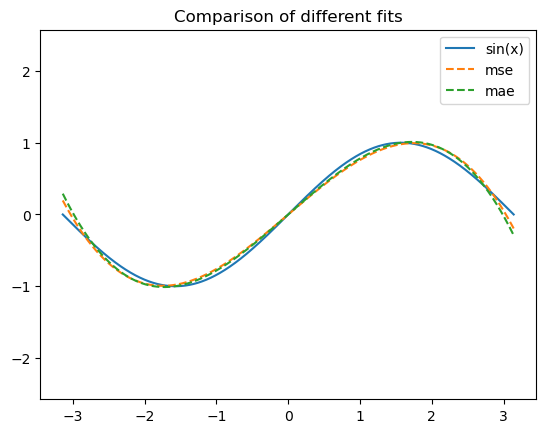

In [7]:
def polyfit(x, y, loss_fn, n, lr, n_iter):
    """
    Parameters
    ----------
        x : A tensor of shape (1, n)
        y : A tensor of shape (1, n)
        loss_fn : Function to measure loss
        n : The nth-degree polynomial
        lr : Learning rate
        n_iter : The number of iterations of gradient descent
        
    Returns
    -------
        Near-optimal coefficients of the nth-degree polynomial as a tensor of shape (1, n+1) after `n_iter` epochs.
    """
    #initializing weights to zero
    weights = torch.zeros(n + 1, requires_grad = True)
    
    features = torch.stack([x ** i for i in range(n + 1)], dim=1)
    
    for _ in range(n_iter):
        y_pred = torch.matmul(features, weights)
        
        loss = loss_fn(y, y_pred)
        
        loss.backward()
        
        with torch.no_grad():
            weights -= lr * weights.grad
            
        weights.grad.zero_()
    return weights
    

x = torch.linspace(-math.pi, math.pi, 1000)

# Original true values
y = torch.sin(x)
plt.plot(x, y, linestyle='solid', label='sin(x)')

# MSE
mse = lambda y_true, y_pred: torch.mean(torch.square(y_pred - y_true))
a, b, c, d = polyfit(x, y, mse, 3, 1e-3, 5000)
y_pred_mse = a + b * x + c * x ** 2 + d * x ** 3
plt.plot(x, y_pred_mse.detach().numpy(), linestyle='dashed', label=f'mse')

# MAE
mae = lambda y_true, y_pred: torch.mean(torch.abs(y_pred - y_true))
a, b, c, d = polyfit(x, y, mae, 3, 1e-3, 5000)
y_pred_mae = a + b * x + c * x ** 2 + d * x ** 3
plt.plot(x, y_pred_mae.detach().numpy(), linestyle='dashed', label=f'mae')

plt.axis('equal')
plt.title('Comparison of different fits')
plt.legend()
plt.show()

In [8]:
x = torch.linspace(-math.pi, math.pi, 10)
y = torch.sin(x)

def mse(y_true, y_pred):
    assert y_true.shape == y_pred.shape, f"Your ground truth and predicted values need to have the same shape {y_true.shape} vs {y_pred.shape}"
    return torch.mean(torch.square(y_pred - y_true))
def mae(y_true, y_pred):
    assert y_true.shape == y_pred.shape, f"Your ground truth and predicted values need to have the same shape {y_true.shape} vs {y_pred.shape}"
    return torch.mean(torch.abs(y_pred - y_true))

test1 = polyfit(x, x, mse, 1, 1e-1, 100).tolist()
test2 = polyfit(x, x**2, mse, 2, 1e-2, 2000).tolist()
test3 = polyfit(x, y, mse, 3, 1e-3, 5000).tolist()
test4 = polyfit(x, y, mae, 3, 1e-3, 5000).tolist()

assert allclose(test1, [0.0, 1.0], atol=1e-6)
assert allclose(test2, [0.0, 0.0, 1.0], atol=1e-5)
assert allclose(test3, [0.0, 0.81909, 0.0, -0.08469], atol=1e-3)
assert allclose(test4, [0.0, 0.83506, 0.0, -0.08974], atol=1e-3)

### Task 1.3 - Observations on different model configurations

Run `polyfit` on these model configurations and explain your observations for <b>ALL</b> four configurations. Refer to the learning rate and degree of the polynomial when making observations regarding how well the model converges if at all.

1. `polyfit(x, y, mse, 3, 1e-6, 5000)`
2. `polyfit(x, y, mse, 3, 1e6, 5000)`
3. `polyfit(x, y, mse, 1, 1e-3, 5000)`
4. `polyfit(x, y, mse, 6, 1e-3, 5000)`

In [9]:
# You may use this cell to run your observations

polyfit(x, y, mse, 6, 1e-6, 5000)

tensor([ 5.6446e-12,  6.6241e-03,  1.5746e-12,  1.4763e-02, -1.3753e-12,
        -9.2899e-04,  3.0985e-12], requires_grad=True)

---
# 2 Computing gradients for arbitrary graphs

Recall the neural network for `y = |x-1|` from the lecture. We are going to implement forward propagation as mentioned during lecture. This forward pass is the act of feeding data into our input layer, which will then be passed to and processed by the hidden layers according to the different activation functions specific to each perceptron. After passing through all the hidden layers, our neural network will generate an output, $\hat{y}$, that is hopefully meaningful to our problem at hand.

<img src="imgs/img_toy_nn.jpg" width="400">

### Task 2.1 - Forward pass

In this task, you are required implement the function `forward_pass` that takes in 4 arguments:  
1. `x`, the input values (not including bias)
2. `w0`, (2x2) weights of the hidden layer
3. `w1`, (3x1) weights of the output layer
4. `activation_fn`, the activation function of the hidden layer.

*Note: As in the lecture, there will be no activation for the output layer (i.e. the activation function of the output layer is the identity function `lambda x: x`)*

In [10]:
x = torch.linspace(-10, 10, 1000).reshape(-1, 1)
y = torch.abs(x-1)

def forward_pass(x, w0, w1, activation_fn):
    x_bias = torch.cat((torch.ones(x.shape[0], 1), x), dim = 1)
    
    hidden = activation_fn(torch.matmul(x_bias, w0))
    
    hidden_bias = torch.cat((torch.ones(hidden.shape[0], 1), hidden), dim=1)
    
    output = torch.matmul(hidden_bias, w1)
    
    return output

# Exact weights
w0 = torch.tensor([[-1., 1.], [1., -1.]], requires_grad=True)
w1 = torch.tensor([[0.], [1.], [1.]], requires_grad=True)

# Performing a forward pass on exact solution for weights will give us the correct y values
x_sample = torch.linspace(-2, 2, 5).reshape(-1, 1)
forward_pass(x_sample, w0, w1, torch.relu) # tensor([[3.], [2.], [1.], [0.], [1.]])

tensor([[3.],
        [2.],
        [1.],
        [0.],
        [1.]], grad_fn=<MmBackward0>)

In [11]:
w0 = torch.tensor([[-1., 1.], [1., -1.]], requires_grad=True)
w1 = torch.tensor([[0.], [1.], [1.]], requires_grad=True)

output0 = forward_pass(torch.linspace(0,1,50).reshape(-1, 1), w0, w1, torch.relu)
x_sample = torch.linspace(-2, 2, 5).reshape(-1, 1)
test1 = forward_pass(x_sample, w0, w1, torch.relu).tolist()
output1 = [[3.], [2.], [1.], [0.], [1.]]

assert output0.shape == torch.Size([50, 1])
assert test1 == output1

### Task 2.2 - Backward propagation

In this task, you will start with random weights for `w0` and `w1`, and iteratively perform forward passes and backward propagation multiple times to converge on a solution.

Submit your values of `w0`, `w1`, and `loss` value onto Coursemology. Your `loss` value should be less than 1.

iter	loss	
----	----
1000	0.5422186255455017
2000	0.16432303190231323
3000	0.051757946610450745
4000	0.020517099648714066
5000	0.011648141779005527
6000	0.0087615717202425
7000	0.007547794375568628
8000	0.006862848065793514
9000	0.006383050698786974
10000	0.006001838482916355
--- w0 ---
tensor([[-1.1462,  0.5324],
        [ 0.7517, -1.3960]], requires_grad=True)
--- w1 ---
tensor([[0.5320],
        [1.3285],
        [0.7253]], requires_grad=True)
0.006001838482916355


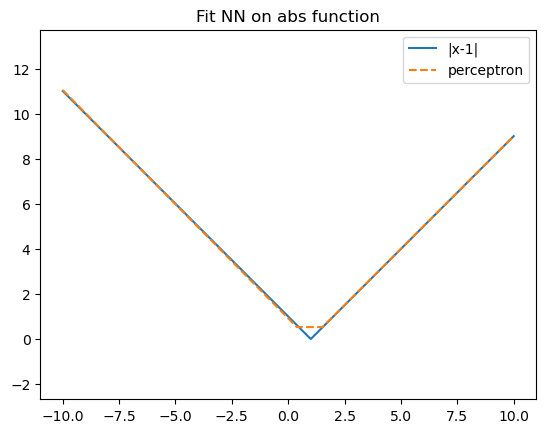

In [15]:
torch.manual_seed(7) # Set seed to some fixed value

w0 = torch.randn(2, 2, requires_grad=True)
w1 = torch.randn(3, 1, requires_grad=True)

learning_rate = 1e-3
print('iter', 'loss', '\n----', '----', sep='\t')
for t in range(1, 10001):
    # Forward pass: compute predicted y
    y_pred = forward_pass(x, w0, w1, torch.relu)

    loss = torch.mean(torch.square(y - y_pred))
    loss.backward()

    if t % 1000 == 0:
        print(t, loss.item(), sep='\t')

    with torch.no_grad():
        # Update weights and then reset the gradients to zero
        w0 -= learning_rate * w0.grad
        w1 -= learning_rate * w1.grad
        
        w0.grad.zero_()
        w1.grad.zero_()

print("--- w0 ---", w0, sep='\n')
print("--- w1 ---", w1, sep='\n')
print(loss.item())
y_pred = forward_pass(x, w0, w1, torch.relu)
plt.plot(x, y, linestyle='solid', label='|x-1|')
plt.plot(x, y_pred.detach().numpy(), linestyle='dashed', label='perceptron')
plt.axis('equal')
plt.title('Fit NN on abs function')
plt.legend()
plt.show()

# Task 5: Submit the values of `w0`, `w1`, and `loss` values after fitting
# Note: An acceptable loss value should be less than 1.0
#       You should try adjusting the random seed, learning rate, or 
#       number of iterations to improve your model.

In [17]:
w0 = torch.tensor(w0)
w1 = torch.tensor(w1)

x = torch.linspace(-10, 10, 1000).reshape(-1, 1)
y = torch.abs(x-1)

#IMPORTANT: Your forward pass above have to be correctly implemented
y_pred = forward_pass(x, w0, w1, torch.relu)
computed_mse_loss = torch.mean(torch.square(y - y_pred)).item()

assert loss < 1
assert isclose(computed_mse_loss, loss, atol=1e-5, rtol=1e-2)

C:\Users\wenji\AppData\Local\Temp\ipykernel_35396\1303024021.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w0 = torch.tensor(w0)
C:\Users\wenji\AppData\Local\Temp\ipykernel_35396\1303024021.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w1 = torch.tensor(w1)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

### Task 2.3 - Different random seeds

Try to fit the model on different initial random weight values by adjusting the random seed. 
<br/>
What is the impact of a random seed? How should we compare different neural network models given your observation to ensure fairness?

Submit your observations and conclusion on Coursemology.

---

# 3 Neural Networks (using PyTorch layers)

### 3.1.1 Demo - nn.Module

The `nn.Module` class is an interface that houses two main methods: `__init__`, where we instantiate our layers and activation functions, and `forward`, that performs the forward pass.

To create our own neural network, we will inherit from the nn.Module parent class and call `super().__init__()` from within our constructor to create our module. Next, we will implement the `forward` function within our class so we can call it from our module to perform the forward pass. 

In this example, we define a custom LinearLayer class that inherits from nn.Module. The __init__ method initializes the weight and bias parameters as nn.Parameter objects, which are special types of tensors that require gradients to be computed during the backward pass.

The forward method defines the forward pass of the linear layer. It takes a tensor x as input and computes the matrix multiplication of x and self.weight using the torch.matmul function, and then adds self.bias.

We also created our own activation function which uses `torch.sin` by inheriting from nn.Module.

Finally, in our Model, we can combine our own LinearLayers together with our SineActivation to process our input data using the forward function. In later sections, you will see how we can train our models.

In [18]:
# Define a linear layer using nn.Module
class LinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(input_dim, output_dim))
        self.bias = nn.Parameter(torch.randn(output_dim))

    def forward(self, x):
        return torch.matmul(x, self.weight) + self.bias
    
class SineActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Model, self).__init__()
        self.l1 = LinearLayer(input_size, hidden_size)
        self.act = SineActivation()
        self.l2 = LinearLayer(hidden_size, num_classes)

    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x
    
input_size = 1
hidden_size = 1
num_classes = 1

model = Model(input_size, hidden_size, num_classes)

x = torch.tensor([[1.0]])
output = model(x)
print("Original value: ", x)
print("Value after being processed by Model: ", output)


Original value:  tensor([[1.]])
Value after being processed by Model:  tensor([[-1.3309]], grad_fn=<AddBackward0>)


_Extra: We can also define a `backward` function to perform backpropagation which will not be required in this problem set._

In this trivial example, the Squared module takes an input x and returns x**2. The backward method calculates the gradient of the output with respect to the input, based on the gradients of the output grad_output.

We can define the backward function for functions that are not fully differentiable that we still wish to use in our neural network.

In [21]:
class Squared(nn.Module):
    def forward(self, x):
        self.x = x
        return x**2

    def backward(self, grad_output):
        grad_input = 2 * self.x * grad_output
        return grad_input

### 3.1.2 Demo - Activation Functions

Pytorch also provides built-in activation functions. To help you understand more about activation functions, we have included some examples of activation functions introduced in the lecture, namely Sigmoid, Tanh, and ReLu. 

<img src="imgs/img_activation_fns.png" width="200">  

Activation functions introduces non-linearity into the output of a neuron, allowing the NN to learn non-linear functions. Without non-linearity, our entire network will effectively become a linear model with only one layer, preventing us from modelling complex representations based on our inputs.

Sigmoid, Tanh and ReLU are three examples of such activation functions introduced during lecture and the code block below shows how they map input to output values.

The choice of activation function for the hidden layers and the output layer depends on the problem you're trying to solve.

####  For the hidden layers, there are several commonly used activation functions:

ReLU (Rectified Linear Unit): ReLU is a popular activation function that is widely used in deep learning models. It maps non-positive inputs to 0 and positive inputs to their original value. It is mainly used in hidden layers because it is fast to compute, has sparse activations, and helps to mitigate the vanishing gradient problem, where the gradients can become very small and cause the model to learn slowly.

Tanh (Hyperbolic Tangent): Tanh is a activation function that maps input values to the range [-1, 1]. It is similar to Sigmoid, but instead of producing output values in the range [0, 1], it produces output values in the range [-1, 1]. Tanh is useful for solving problems where you want the activations to be centered around zero, such as in recurrent neural networks.

Sigmoid: Sigmoid maps its input values to the range [0, 1]. It is less commonly used in hidden layers because it has a relatively slow convergence rate and can introduce saturation, where the output values become very small or very large, which can make it difficult for the gradients to flow through the model.

#### For the output layer, the choice of activation function depends on the problem you're trying to solve. Here are some common choices:

Sigmoid: The Sigmoid activation function maps input values to the range [0, 1]. It is commonly used for binary classification problems where the network produces a probability of one of two classes. In this case, the Sigmoid activation maps the output to a probability distribution over the two classes.

Softmax: The Softmax activation function is a generalization of the Sigmoid activation that maps input values to a probability distribution over multiple classes. It is commonly used for multiclass classification problems. The Softmax activation function is used to convert the raw scores produced by the network into a probability distribution over the classes.

Linear: For regression problems, the linear activation function is often used because it just maps the input values to the output values without any change.

In summary, ReLU is a common choice for hidden layers, and the choice of activation function for the output layer depends on the problem you're trying to solve (binary classification, multiclass classification, or regression).

---

_Extra (Vanishing Gradient Problem):_

_Below is an image of the derivatives of the Sigmoid, Tanh and ReLU function. We can see that the derivatives for both Sigmoid and Tanh tend to zero when the inputs are largely positive or negative, while derivative for ReLU is zero only when the inputs are non-positive. In our neural network, gradients are calculated through backpropagation using chain rule and the derivatives of each layer are multiplied down the network. The gradient is more likely to decrease exponentially as we propagate down to the initial layers if we use Sigmoid and Tanh as compared to ReLU, leading to the vanishing gradient problem._

<img src="imgs/img_activation_fns_der.png" width="500"> 



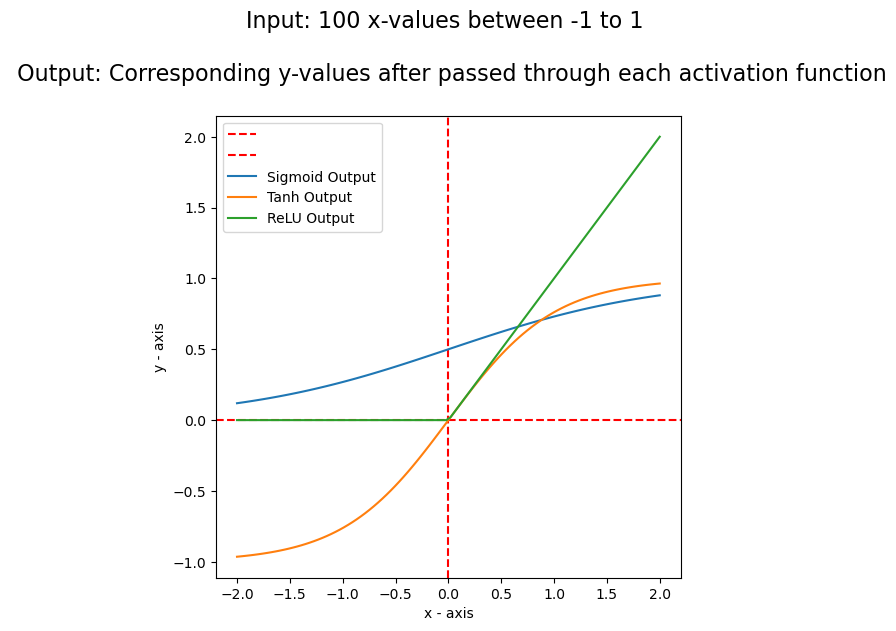

In [22]:
x_sample = torch.linspace(-2, 2, 100)
sigmoid_output = nn.Sigmoid()(x_sample).detach().numpy()
tanh_output = nn.Tanh()(x_sample).detach().numpy()
relu_output = nn.ReLU()(x_sample).detach().numpy()

f = plt.figure()
f.set_figwidth(6)
f.set_figheight(6)
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title("Input: 100 x-values between -1 to 1 \n\n Output: Corresponding y-values after passed through each activation function\n", fontsize=16)
plt.axvline(x=0, color='r', linestyle='dashed')
plt.axhline(y=0, color='r', linestyle='dashed')
plt.plot(x_sample, sigmoid_output)
plt.plot(x_sample, tanh_output)
plt.plot(x_sample, relu_output)
plt.legend(["","","Sigmoid Output", "Tanh Output", "ReLU Output"])
plt.show()

### Task 3.1 - Forward pass

In part 2, you manually created the Linear layers and explicitly specified weights and biases for the forward pass to connect every input neuron to every output neuron which will be extremely tedious for larger networks. 

In this task, you will be using `nn.Linear(in_dimensions, out_dimensions)` provided by pytorch which abstracts all these details away. `nn.Linear` represents a fully connected layer with bias automatically included. We can also choose to remove the bias column by simply calling `nn.Linear(in_dimensions, out_dimensions, bias=False)` instead.

We inherit from PyTorch's `nn.Module` class to build the model from the previous task `y = |x-1|` from the lecture.  

<img src="imgs/img_toy_nn.jpg" width="400"> 

Pytorch is widely used in machine learning due to the ease of being able to combine many different types of layers and activation functions to create neural networks. This task should allow you to appreciate how easily we can build neural networks using PyTorch.  

The model has been built for you in `__init__`. You need to implement the `forward` method, making use of the layers `self.l1`, `self.l2`, and the activation function `self.relu`. You need to combine the linear layers AND the activation function in the forward pass function!

_Extra: PyTorch has many other layers implemented for various model architectures.  
You can read more in the glossary as well as in the docs: https://pytorch.org/docs/stable/nn.html  
For now, we will only be using fully connected `nn.Linear` layers._

In [23]:
class MyFirstNeuralNet(nn.Module):
    def __init__(self): # set the arguments you'd need
        super().__init__()
        self.l1 = nn.Linear(1, 2) # bias included by default
        self.l2 = nn.Linear(2, 1) # bias included by default
        self.relu = nn.ReLU()
 
    # Task 3.1: Forward pass
    def forward(self, x):
        '''
        Forward pass to process input through two linear layers and ReLU activation function.

        Parameters
        ----------
        x : A tensor of of shape (n, 1) where n is the number of training instances

        Returns
        -------
            Tensor of shape (n, 1)
        '''
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        return x

In [24]:
x_sample = torch.linspace(-2, 2, 5).reshape(-1, 1)

model = MyFirstNeuralNet()

state_dict = OrderedDict([
    ('l1.weight', torch.tensor([[1.],[-1.]])),
    ('l1.bias',   torch.tensor([-1., 1.])),
    ('l2.weight', torch.tensor([[1., 1.]])),
    ('l2.bias',   torch.tensor([0.]))
])

model.load_state_dict(state_dict)

student1 = model.forward(x_sample).detach().numpy()
output1 = [[3.], [2.], [1.], [0.], [1.]]

assert allclose(student1, output1, atol=1e-5)

### 3.1.3 Demo - Optimisers in PyTorch

Optimizers in PyTorch are used to update the parameters of a model during training. They do this by computing the gradients of the model's parameters with respect to the loss function, and then using these gradients to update the parameters in a way that minimizes the loss. 

In the following code example, we will simply demo a few basic functionalities of optimisers. Only in 3.1.4 Demo will you see an actual optimizer at work to train a Neural Net.

We first create a tensor x with requires_grad set to True. Next, we define our loss function to be the simple equation y = x ** 2 + 2 * x. Next, we define an optimiser (in this case, Stochastic Gradient Descent, SGD) and pass it our tensor x as a parameter to optimise. After updating the gradient stored in x using `backward()`, we will call the `step()` function to let the optimiser update x. We will then set the gradient of our tensor x back to zero using `zero_grad()`.



In [25]:
x = torch.tensor([1.0], requires_grad=True)

#Loss function
y = x ** 2 + 2 * x

# Define an optimizer, pass it our tensor x to update
optimiser = torch.optim.SGD([x], lr=0.1)

# Perform backpropagation
y.backward()

print("Value of x before it is updated by optimiser: ", x)
print("Gradient stored in x after backpropagation: ", x.grad)

# Call the step function on the optimizer to update weight
optimiser.step()

#Weight update, x = x - lr * x.grad = 1.0 - 0.1 * 4.0 = 0.60
print("Value of x after it is updated by optimiser: ", x)

# Set gradient of weight to zero
optimiser.zero_grad()
print("Gradient stored in x after zero_grad is called: ", x.grad)


Value of x before it is updated by optimiser:  tensor([1.], requires_grad=True)
Gradient stored in x after backpropagation:  tensor([4.])
Value of x after it is updated by optimiser:  tensor([0.6000], requires_grad=True)
Gradient stored in x after zero_grad is called:  tensor([0.])


### 3.1.4 Demo - Training Your First Neural Net

Now, let's make use of an optimiser to train our neural network in Task 3.1!

Take note, if you make changes to your model (e.g. fix any bugs in your forward pass), then you will have to re-run your previous cell to update the model definition.

In the example below, we are applying what we have learnt in the above section about optimisers to train our neural network.

We will using `torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0)` as the optimiser. This SGD optimiser will implement stochastic gradient descent for us. As mentioned previously, `optimiser.zero_grad()` will set all the gradients to zero to prevent accumulation of all the previous old gradients we have calculated using backpropagation. `optimiser.step()` causes our optimiser to update the model weights based on the gradients of our parameters.

We can see clearly from our example below that we are calling `optimiser.zero_grad()` at the start of the loop so we can clear the gradient from the previous iteration of backpropagation. Then after we compute the loss in the current iteration using our loss function and model predictions, y_pred, we will call `loss.backward()` to let pytorch carry out the backpropagation for us. After backpropagation, gradients for each of our parameters will be computed for us to update our model weights using `optimiser.step()`.

Epoch	Loss	
-----	----
 1000	0.3594755530357361
 2000	0.13189829885959625
 3000	0.05977959185838699
 4000	0.030693551525473595
 5000	0.01639617048203945
 6000	0.008692782372236252
 7000	0.004500680603086948
 8000	0.0022789116483181715
 9000	0.0011381905060261488
10000	0.0005686092190444469


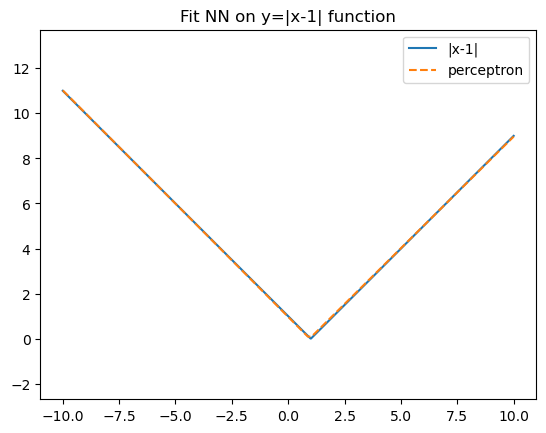

In [26]:
torch.manual_seed(6) # Set seed to some fixed value

epochs = 10000

model = MyFirstNeuralNet()
# the optimizer controls the learning rate
optimiser = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0)
loss_fn = nn.MSELoss()

x = torch.linspace(-10, 10, 1000).reshape(-1, 1)
y = torch.abs(x-1)

print('Epoch', 'Loss', '\n-----', '----', sep='\t')
for i in range(1, epochs+1):
    # reset gradients to 0
    optimiser.zero_grad()
    # get predictions
    y_pred = model(x)
    # compute loss
    loss = loss_fn(y_pred, y)
    # backpropagate
    loss.backward()
    # update the model weights
    optimiser.step()

    if i % 1000 == 0:
        print (f"{i:5d}", loss.item(), sep='\t')

y_pred = model(x)
plt.plot(x, y, linestyle='solid', label='|x-1|')
plt.plot(x, y_pred.detach().numpy(), linestyle='dashed', label='perceptron')
plt.axis('equal')
plt.title('Fit NN on y=|x-1| function')
plt.legend()
plt.show()

### 3.2 Concept - Save and load models

Your model weights are stored within the model itself.  
You may save/load the model weights:
```
torch.save(model.state_dict(), "path/to/model_state_dict")

model = MyFirstNeuralNet()
model.load_state_dict(torch.load("path/to/model_state_dict"))
```

Alternatively, you can save/load the entire model using
```
torch.save(model, "path/to/model")

model = torch.load("path/to/model")
```

### Task 3.2 - Model weights

For this task, you will print out the trained model's `.state_dict()` and submit this to Coursemology.

*Note: An acceptable loss value should be less than 1.0. If your loss is greater than 1, try re-running with a different random initialization, or adjust your model configuration.*

In [73]:
# To submit this output
print("--- Submit the OrderedDict below ---")
print(model.state_dict())

--- Submit the OrderedDict below ---
OrderedDict([('l1.weight', tensor([[ 1.],
        [-1.]])), ('l1.bias', tensor([-1.,  1.])), ('l2.weight', tensor([[1., 1.]])), ('l2.bias', tensor([0.]))])


In [74]:
def get_loss(model):
    model.load_state_dict(state_dict)
    x = torch.linspace(-10, 10, 1000).reshape(-1, 1)
    y = torch.abs(x-1)
    loss_fn = nn.MSELoss()
    y_pred = model.forward(x)
    return loss_fn(y_pred, y).item()

assert model.load_state_dict(state_dict)
assert get_loss(model) < 1

### 3.3 Concept - Using NN to recognize handwritten digits

In the final part of this problem set, we will be building a neural network to classify images to their respective digits.  

You will build and train a model on the classic **MNIST Handwritten Digits** dataset. Each grayscale image is a $28 \times 28$ matrix/tensor that looks like so:

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" width="500" />

MNIST is a classification problem and the task is to take in an input image and classify them into one of ten buckets: the digits from $0$ to $9$. 

### 3.3 Demo - Loading an external dataset

The cell below imports the MNIST dataset, which is already pre-split into train and test sets.  

The download takes approximately 63MB of space.

In [91]:
# DO NOT REMOVE THIS CELL – THIS DOWNLOADS THE MNIST DATASET
# RUN THIS CELL BEFORE YOU RUN THE REST OF THE CELLS BELOW
from torchvision import datasets

# This downloads the MNIST datasets ~63MB
mnist_train = datasets.MNIST("./", train=True, download=True)
mnist_test  = datasets.MNIST("./", train=False, download=True)

x_train = mnist_train.data.reshape(-1, 784) / 255
y_train = mnist_train.targets
    
x_test = mnist_test.data.reshape(-1, 784) / 255
y_test = mnist_test.targets

### Task 3.3 - Define the model architechure and implement the forward pass
Create a 3-layer network in the `__init__` method of the model `DigitNet`.  
These layers are all `Linear` layers and should correspond to the following the architecture:

<img src="imgs/img_linear_nn.png" width="600">

In our data, a given image $x$ has been flattened from a 28x28 image to a 784-length array.

After initializing the layers, stitch them together in the `forward` method. Your network should look like so:

$$x \rightarrow \text{Linear(512)} \rightarrow \text{ReLU} \rightarrow \text{Linear(128)} \rightarrow \text{ReLU} \rightarrow \text{Linear(10)} \rightarrow \text{Softmax} \rightarrow \hat{y}$$

**Softmax Layer**: The final softmax activation is commonly used for classification tasks, as it will normalizes the results into a vector of values that follows a probability distribution whose total sums up to 1. The output values are between the range [0,1] which is nice because we are able to avoid binary classification and accommodate as many classes or dimensions in our neural network model.

*Note: When using `torch.softmax(...)` on the final layer, ensure you are applying it on the correct dimension (as you did in NumPy via the `axis` argument in popular methods)*

In [92]:
class DigitNet(nn.Module):
    def __init__(self, input_dimensions, num_classes): # set the arguments you'd need
        super().__init__()
        """
        YOUR CODE HERE
        - DO NOT hardcode the input_dimensions, use the parameter in the function
        - Your network should work for any input and output size 
        - Create the 3 layers (and a ReLU layer) using the torch.nn layers API
        """
        self.l1 = nn.Linear(input_dimensions, 512)
        self.l2 = nn.Linear(512, 128)
        self.l3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        """
        Performs the forward pass for the network.
        
        Parameters
        ----------
        x : Input tensor (batch size is the entire dataset)

        Returns
        -------
            The output of the entire 3-layer model.
        """
        
        """
        YOUR CODE
        
        - Pass the inputs through the sequence of layers
        - Run the final output through the Softmax function on the right dimension!
        """
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = torch.softmax(x, dim = 1)
        return x
        

In [93]:
model = DigitNet(784, 10)
assert [layer.detach().numpy().shape for name, layer in model.named_parameters()] \
        == [(512, 784), (512,), (128, 512), (128,), (10, 128), (10,)]

### Task 3.4 - Training Loop

As demonstrated in Section 3.2, implement the function `train_model` that performs the following for every epoch/iteration:

1. set the optimizer's gradients to zero
2. forward pass
3. calculate the loss
4. backpropagate using the loss
5. take an optimzer step to update weights

This time, use the Adam optimiser to train the network.
<br/>
<br/>
Use Cross-Entropy Loss, since we are performing a classification.
<br/>
_(PyTorch Softmax normalize logits while CrossEntropyLoss accepts unnormalized logits and CrossEntropyLoss already applies LogSoftmax, however, we will use Softmax here as we want to showcase how Softmax can convert the raw scores produced by the network into a probability distribution over the classes)._
<br/>
<br/>
Train for 20 epochs.  

*Note: refer to the command glossary to find out how to instantiate optimisers, losses, and more*

In [98]:
def train_model(x_train, y_train, epochs=20):
    """
    Trains the model for 20 epochs/iterations
    
    Parameters
    ----------
        x_train : A tensor of training features of shape (60000, 784)
        y_train : A tensor of training labels of shape (60000, 1)
        epochs  : Number of epochs, default of 20
        
    Returns
    -------
        The final model 
    """
    model = DigitNet(784, 10)
    optimiser = torch.optim.Adam(model.parameters(), lr = 1e-3) # use Adam
    loss_fn = nn.CrossEntropyLoss()   # use CrossEntropyLoss

    for i in range(epochs):
        optimiser.zero_grad()
        y_pred = model(x_train)
        
        #compute loss
        loss = loss_fn(y_pred, y_train)
        
        #backpropagate
        loss.backward()
        
        #update model weights
        optimiser.step()

    return model
                
digit_model = train_model(x_train, y_train)

In [99]:
x_train_new = torch.rand(5, 784, requires_grad=True)
y_train_new = ones = torch.ones(5, dtype=torch.uint8)

assert type(train_model(x_train_new, y_train_new)) == DigitNet

### 3.5 Demo - Explore your model

Now that we have trained the model, let us run some predictions on the model.

true label: 7
pred label: 7


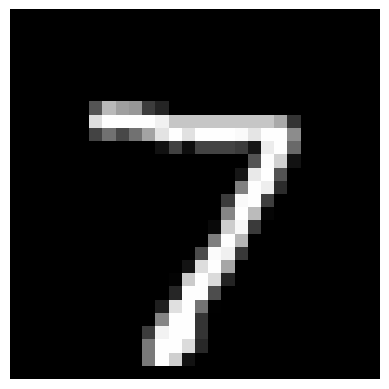

In [100]:
# This is a demonstration: You can use this cell for exploring your trained model

idx = 0 # try on some index

scores = digit_model(x_test[idx:idx+1])
_, predictions = torch.max(scores, 1)
print("true label:", y_test[idx].item())
print("pred label:", predictions[0].item())

plt.imshow(x_test[idx].numpy().reshape(28, 28), cmap='gray')
plt.axis("off")
plt.show()

### Task 3.5 - Evaluate the model

Now that we have trained the model, we should evaluate it using our test set.  
We will be using the accuracy (whether or not the model predicted the correct label) to measure the model performance.  

Since our model takes in a (n x 784) tensor and returns a (n x 10) tensor of probability scores for each of the 10 classes, we need to convert the probability scores into the actual predictions by taking the index of the maximum probability.  

In [103]:
def get_accuracy(scores, labels):
    """
    Helper function that returns accuracy of model
    
    Parameters
    ----------
        scores : The raw softmax scores of the network
        labels : The ground truth labels
        
    Returns
    -------
        Accuracy of the model. Return a number in range [0, 1].
        0 means 0% accuracy while 1 means 100% accuracy
    """
    #find max probability score for each sample
    maxValue, index = torch.max(scores, dim = 1)
    
    #extract all indexes with correct prediction
    indexSum = torch.sum(index == labels).item()
    
    return indexSum / len(labels)

scores = digit_model(x_test) # n x 10 tensor
get_accuracy(scores, y_test)

0.7777

In [104]:
scores = torch.tensor([[0.4118, 0.6938, 0.9693, 0.6178, 0.3304, 0.5479, 0.4440, 0.7041, 0.5573,
         0.6959],
        [0.9849, 0.2924, 0.4823, 0.6150, 0.4967, 0.4521, 0.0575, 0.0687, 0.0501,
         0.0108],
        [0.0343, 0.1212, 0.0490, 0.0310, 0.7192, 0.8067, 0.8379, 0.7694, 0.6694,
         0.7203],
        [0.2235, 0.9502, 0.4655, 0.9314, 0.6533, 0.8914, 0.8988, 0.3955, 0.3546,
         0.5752],
        [0,0,0,0,0,0,0,0,0,1]])
y_true = torch.tensor([5, 3, 6, 4, 9])
acc_true = 0.4
assert isclose(get_accuracy(scores, y_true),acc_true) , "Mismatch detected"
print("passed")

passed


# Submission

Once you are done, please remember to submit your work to Coursemology, by copying the right snippets of code into the corresponding box that says "Your answer", and click "Save". After you save, you can make changes to your submission.

Once you are satisfied with what you have uploaded, click "Finalize submission". **Note that once your submission is finalized, it is considered to be submitted for grading and cannot be changed.** If you need to undo this action, you will have to reach out to your assigned tutor for help. Please do not finalize your submission until you are sure that you want to submit your solutions for grading. 

### HAVE FUN AND ENJOY CODING!